# Libraries

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.9 MB/s eta 0:00:00


In [ ]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import torch
import time
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset


from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    XLMRobertaTokenizer,
    EarlyStoppingCallback,
    TrainerCallback
)

# Load Dataset

In [ ]:
# Path each dataset
dataset_path = "/content/Indonesia_9008.csv"
singkatan_dict_path = "/content/new_kamusalay.csv"
emoji_dict_path = "/content/emoji_to_text.csv"

# Load dataset utama
df = pd.read_csv(dataset_path)

 # Memuat kamus alay
kamus_alay = pd.read_csv('/content/new_kamusalay.csv', sep=',', header=None, names=['alay', 'full'], encoding='ISO-8859-1')
kamus_alay_dict = dict(zip(kamus_alay['alay'], kamus_alay['full']))

# Load kamus emoji
emoji_df = pd.read_csv(emoji_dict_path)
emoji_dict = dict(zip(emoji_df['emoji'], emoji_df['makna']))

# Cek info dataset Indonesia
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9008 entries, 0 to 9007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9008 non-null   object
 1   label   9008 non-null   object
dtypes: object(2)
memory usage: 140.9+ KB


# Data Pre processing

## 1. Class Distribution

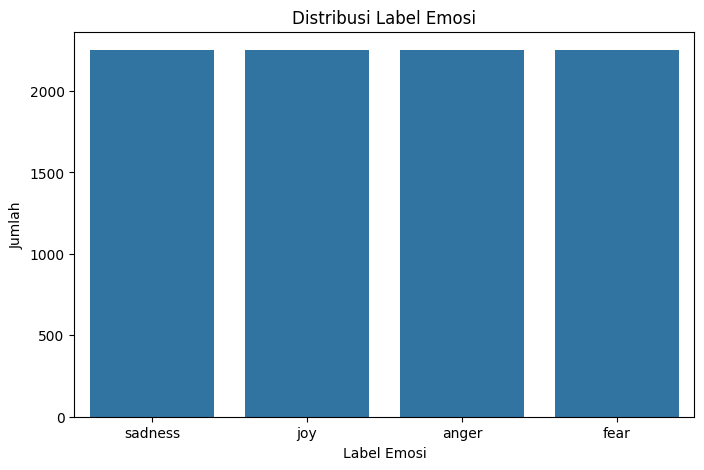

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Distribusi Label Emosi')
plt.xlabel('Label Emosi')
plt.ylabel('Jumlah')
plt.show()

## 2. Text Cleaning

In [ ]:
# Convert Emoji
def convert_emoji(text, emoji_dict):
    for emo, meaning in emoji_dict.items():
        text = text.replace(emo, f" {meaning} ")
    return text

#Text Normalization
def normalize_text(text, singkatan_dict):
    words = text.split()
    normalized = [kamus_alay_dict.get(word.lower(), word) for word in words]
    return ' '.join(normalized)

# Noise Character Removal
def clean_text(text):
    text = re.sub(r'#(\w+)', r' \1 ', text)
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'ðŸ[^ ]*', '', text)
    text = re.sub(r'[-/]', ' ', text)
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    text = re.sub(r'\.{3,}', 'elipsis', text)

    allowed_punct = '!?'
    text = ''.join(char for char in text if char.isalpha() or char.isspace() or char in allowed_punct or char == 'elipsis')

    text = text.replace('elipsis', '...')

    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Case Folding
def to_lowercase(text):
    return text.lower()

def preprocess_text(text, kamus_alay_dict, emoji_dict):
    text = str(text)
    text = convert_emoji(text, emoji_dict)
    text = normalize_text(text, kamus_alay_dict)
    text = clean_text(text)
    text = to_lowercase(text)
    return text

In [ ]:
# Backup kolom asli
df['text_original'] = df['text']

# Output per step
df['text_emoji'] = df['text_original'].apply(lambda x: convert_emoji(x, emoji_dict))
df['text_normalized'] = df['text_emoji'].apply(lambda x: normalize_text(x, kamus_alay_dict))
df['text_cleaned'] = df['text_normalized'].apply(clean_text)
df['text_lowercase'] = df['text_cleaned'].apply(to_lowercase)

# Simpan hasil akhir ke kolom final
df['text_clean'] = df['text_lowercase']


In [ ]:
df[['label', 'text_original', 'text_emoji', 'text_normalized', 'text_cleaned', 'text_lowercase', 'text_clean']].head(100)

,label,text_original,text_emoji,text_normalized,text_cleaned,text_lowercase,text_clean
0,sadness,Jaringan yang terus memburuk membuat hari-hari...,Jaringan yang terus memburuk membuat hari-hari...,Jaringan yang terus memburuk membuat hari-hari...,Jaringan yang terus memburuk membuat hari hari...,jaringan yang terus memburuk membuat hari hari...,jaringan yang terus memburuk membuat hari hari...
1,joy,@kudila_ wah keren banget Telkomsel Awards 202...,@kudila_ wah keren banget Telkomsel Awards 202...,@kudila_ wah keren banget Telkomsel Awards 202...,wah keren banget Telkomsel Awards ada zayyan j...,wah keren banget telkomsel awards ada zayyan j...,wah keren banget telkomsel awards ada zayyan j...
2,sadness,@Telkomsel Paket 4G Ceria saya tolong jangan d...,@Telkomsel Paket 4G Ceria saya tolong jangan d...,@Telkomsel Paket 4G Ceria saya tolong jangan d...,Paket Ceria saya tolong jangan dihilangkan Itu...,paket ceria saya tolong jangan dihilangkan itu...,paket ceria saya tolong jangan dihilangkan itu...
3,anger,Pas banget dari dulu Telkomsel selalu mengecew...,Pas banget dari dulu Telkomsel selalu mengecew...,Pas banget dari dulu Telkomsel selalu mengecew...,Pas banget dari dulu Telkomsel selalu mengecew...,pas banget dari dulu telkomsel selalu mengecew...,pas banget dari dulu telkomsel selalu mengecew...
4,fear,Gangguan yang sering terjadi di Indosat membua...,Gangguan yang sering terjadi di Indosat membua...,Gangguan yang sering terjadi di Indosat membua...,Gangguan yang sering terjadi di Indosat membua...,gangguan yang sering terjadi di indosat membua...,gangguan yang sering terjadi di indosat membua...
...,...,...,...,...,...,...,...
95,joy,@xodiac_id @Telkomsel Mantap @XODIACOfficial ð...,@xodiac_id @Telkomsel Mantap @XODIACOfficial ð...,@xodiac_id @Telkomsel Mantap @XODIACOfficial ð...,Mantap Zayyan pulang kampung... kayak Dita di ...,mantap zayyan pulang kampung... kayak dita di ...,mantap zayyan pulang kampung... kayak dita di ...
96,fear,"Telkomsel meluncurkan layanan baru, jadi saya ...","Telkomsel meluncurkan layanan baru, jadi saya ...","Telkomsel meluncurkan layanan baru, jadi saya ...",Telkomsel meluncurkan layanan baru jadi saya a...,telkomsel meluncurkan layanan baru jadi saya a...,telkomsel meluncurkan layanan baru jadi saya a...
97,anger,@Telkomsel Sinyal jelek parah dari kemarin sam...,@Telkomsel Sinyal jelek parah dari kemarin sam...,@Telkomsel Sinyal jelek parah dari kemarin sam...,Sinyal jelek parah dari kemarin sampai sekaran...,sinyal jelek parah dari kemarin sampai sekaran...,sinyal jelek parah dari kemarin sampai sekaran...
98,sadness,@Telkomsel Saya beli paket yang harusnya aktif...,@Telkomsel Saya beli paket yang harusnya aktif...,@Telkomsel Saya beli paket yang harusnya aktif...,Saya beli paket yang harusnya aktif sampai Agu...,saya beli paket yang harusnya aktif sampai agu...,saya beli paket yang harusnya aktif sampai agu...


## 3. Label Encoding

In [ ]:
emotion_dict = {'anger': 0, 'joy': 1, 'fear': 2, 'sadness': 3}
df['label'] = df['label'].apply(lambda x: emotion_dict[x])

## 4. Tokenizing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=128)

encoded_df = df['text_clean'].apply(tokenize_function)
df['input_ids'] = encoded_df.apply(lambda x: x['input_ids'])
df['attention_mask'] = encoded_df.apply(lambda x: x['attention_mask'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
# Output Tokenizing
sample_text = df['text_clean'].iloc[57]  # atau ganti dengan index lain
encoded_sample = tokenizer(sample_text, truncation=True, padding="max_length", max_length=128)

print("Original Clean Text:")
print(sample_text)

print("\nInput IDs:")
print(encoded_sample['input_ids'])

print("\nTokens:")
print(tokenizer.convert_ids_to_tokens(encoded_sample['input_ids']))

print("\nAttention Mask:")
print(encoded_sample['attention_mask'])

Original Clean Text:
nomor saya tiba tiba menjadi tidak aktif wajah ketakutan takutnya tidak bisa aktif lagi

Input IDs:
[0, 71161, 1216, 30860, 30860, 2253, 762, 30581, 26053, 215866, 45496, 273, 762, 1485, 30581, 2214, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Tokens:
['<s>', '▁nomor', '▁saya', '▁tiba', '▁tiba', '▁menjadi', '▁tidak', '▁aktif', '▁wajah', '▁ketakutan', '▁takut', 'nya', '▁tidak', '▁bisa', '▁aktif', '▁lagi', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

# Build Model

## Split Dataset

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Cek hasil split
print(f"Jumlah train_data: {len(train_df)}")
print(f"Jumlah val_data: {len(val_df)}")

Jumlah train_data: 7206
Jumlah val_data: 1802


In [ ]:
# Convert ke Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

## Load Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

## Epoch 3

In [ ]:
def get_patience(total_epoch):
    return min(2, total_epoch // 3)

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
    }

training_args = TrainingArguments(
    output_dir="./results_epoch3",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs_epoch3",
    logging_steps=10,
    load_best_model_at_end=True,
    dataloader_drop_last=False,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="tensorboard",
)

patience_value = get_patience(training_args.num_train_epochs)
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=patience_value
)

class TimestampCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        print(f"Epoch {state.epoch} completed in {epoch_duration:.2f} seconds.")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping, TimestampCallback],
)

<ipython-input-14-20963c2f7889>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.388300,0.226919,0.933962
2,0.195200,0.194190,0.956715
3,0.077700,0.230233,0.952830


Epoch 1.0 completed in 92.83 seconds.
Epoch 2.0 completed in 93.07 seconds.
Epoch 3.0 completed in 93.20 seconds.


TrainOutput(global_step=1353, training_loss=0.25147512092558616, metrics={'train_runtime': 404.8575, 'train_samples_per_second': 53.397, 'train_steps_per_second': 3.342, 'total_flos': 1422009233528832.0, 'train_loss': 0.25147512092558616, 'epoch': 3.0})

### Confusion Matrix

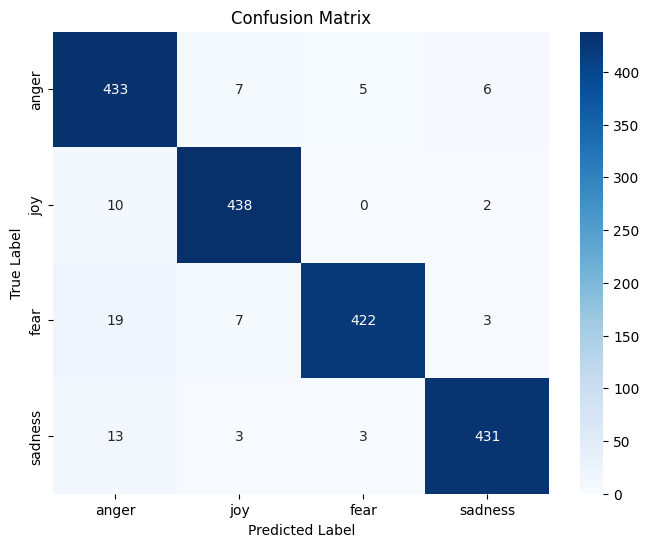

In [ ]:
# Confusion matrix
preds_output = trainer.predict(val_dataset)
true_labels = preds_output.label_ids
predicted_labels = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
labels = ['anger', 'joy', 'fear', 'sadness']

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Accuracy

In [ ]:
predictions = trainer.predict(val_dataset)
true_labels = predictions.label_ids
predicted_probs = predictions.predictions
predicted_labels = np.argmax(predicted_probs, axis=1)

# Classification Report
print("=== Classification Report ===")
print(classification_report(true_labels, predicted_labels, digits=6))

# Akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.6f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0   0.911579  0.960089  0.935205       451
           1   0.962637  0.973333  0.967956       450
           2   0.981395  0.935698  0.958002       451
           3   0.975113  0.957778  0.966368       450

    accuracy                       0.956715      1802
   macro avg   0.957681  0.956725  0.956883      1802
weighted avg   0.957669  0.956715  0.956871      1802

Accuracy: 0.956715


## Epoch 5

In [ ]:
def get_patience(total_epoch):
    return min(2, total_epoch // 3)

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
    }

training_args = TrainingArguments(
    output_dir="./results_epoch5",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs_epoch5",
    logging_steps=10,
    load_best_model_at_end=True,
    dataloader_drop_last=False,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="tensorboard",
)

patience_value = get_patience(training_args.num_train_epochs)
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=patience_value
)

class TimestampCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        print(f"Epoch {state.epoch} completed in {epoch_duration:.2f} seconds.")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping, TimestampCallback],
)


<ipython-input-19-b03166bacfa0>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.070700,0.352717,0.938957
2,0.142800,0.238936,0.951720
3,0.020000,0.270576,0.959489
4,0.015500,0.276711,0.961709
5,0.042400,0.278982,0.962819


Epoch 1.0 completed in 92.87 seconds.
Epoch 2.0 completed in 93.35 seconds.
Epoch 3.0 completed in 93.11 seconds.
Epoch 4.0 completed in 93.35 seconds.
Epoch 5.0 completed in 93.09 seconds.


TrainOutput(global_step=2255, training_loss=0.07181821720893526, metrics={'train_runtime': 670.8205, 'train_samples_per_second': 53.71, 'train_steps_per_second': 3.362, 'total_flos': 2370015389214720.0, 'train_loss': 0.07181821720893526, 'epoch': 5.0})

### Confusion Matrix

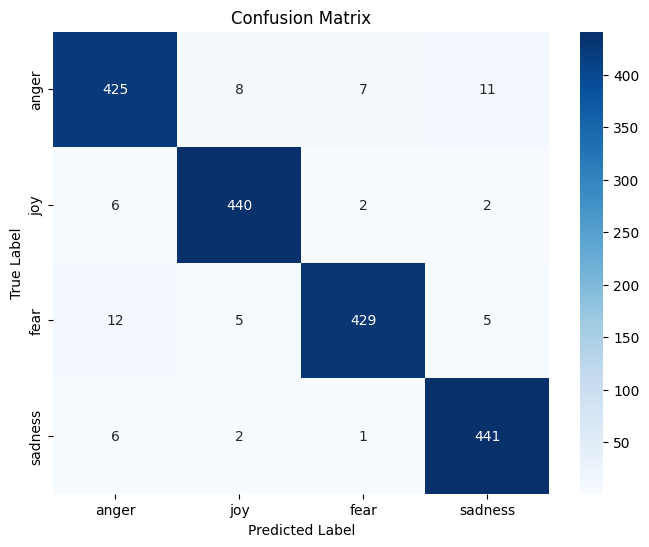

In [ ]:
# Confusion matrix
preds_output = trainer.predict(val_dataset)
true_labels = preds_output.label_ids
predicted_labels = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
labels = ['anger', 'joy', 'fear', 'sadness']

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Accuracy

In [ ]:
predictions = trainer.predict(val_dataset)
true_labels = predictions.label_ids
predicted_probs = predictions.predictions
predicted_labels = np.argmax(predicted_probs, axis=1)

# Classification Report
print("=== Classification Report ===")
print(classification_report(true_labels, predicted_labels, digits=6))

# Akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.6f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0   0.946548  0.942350  0.944444       451
           1   0.967033  0.977778  0.972376       450
           2   0.977221  0.951220  0.964045       451
           3   0.960784  0.980000  0.970297       450

    accuracy                       0.962819      1802
   macro avg   0.962897  0.962837  0.962791      1802
weighted avg   0.962895  0.962819  0.962781      1802

Accuracy: 0.962819


## Epoch 10

In [ ]:
def get_patience(total_epoch):
    return min(2, total_epoch // 3)

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
    }

training_args = TrainingArguments(
    output_dir="./results_epoch10",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs_epoch10",
    logging_steps=10,
    load_best_model_at_end=True,
    dataloader_drop_last=False,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="tensorboard",
)

patience_value = get_patience(training_args.num_train_epochs)
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=patience_value
)

class TimestampCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        print(f"Epoch {state.epoch} completed in {epoch_duration:.2f} seconds.")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping, TimestampCallback],
)


<ipython-input-24-40edfbb62420>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.045000,0.455098,0.936182
2,0.090100,0.399456,0.940622
3,0.028200,0.337637,0.953385
4,0.007100,0.334971,0.954495
5,0.000100,0.387663,0.953385
6,0.008300,0.360551,0.957825
7,0.000000,0.354364,0.960044
8,0.000000,0.383073,0.956715
9,0.035400,0.320023,0.963374
10,0.053400,0.347846,0.960599


Epoch 1.0 completed in 93.40 seconds.
Epoch 2.0 completed in 93.34 seconds.
Epoch 3.0 completed in 93.15 seconds.
Epoch 4.0 completed in 93.08 seconds.
Epoch 5.0 completed in 93.42 seconds.
Epoch 6.0 completed in 93.25 seconds.
Epoch 7.0 completed in 93.30 seconds.
Epoch 8.0 completed in 93.10 seconds.
Epoch 9.0 completed in 93.24 seconds.
Epoch 10.0 completed in 93.21 seconds.


TrainOutput(global_step=4510, training_loss=0.02794096216073744, metrics={'train_runtime': 1333.3111, 'train_samples_per_second': 54.046, 'train_steps_per_second': 3.383, 'total_flos': 4740030778429440.0, 'train_loss': 0.02794096216073744, 'epoch': 10.0})

### Confusion Matrix

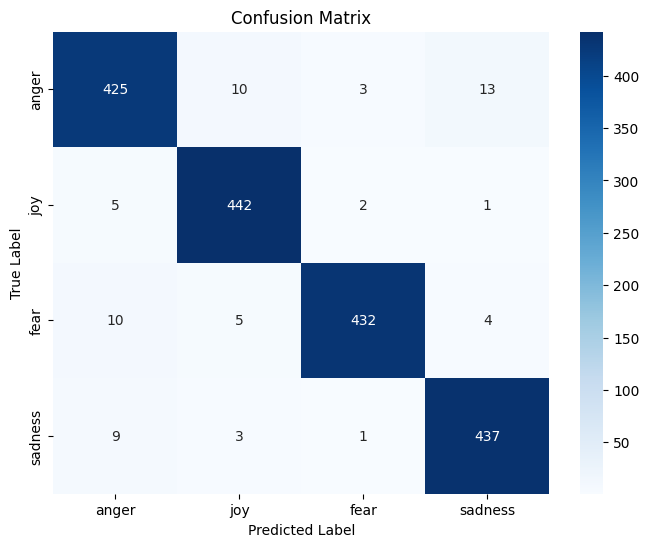

In [ ]:
# Confusion matrix
preds_output = trainer.predict(val_dataset)
true_labels = preds_output.label_ids
predicted_labels = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
labels = ['anger', 'joy', 'fear', 'sadness']

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Accuracy

In [ ]:
predictions = trainer.predict(val_dataset)
true_labels = predictions.label_ids
predicted_probs = predictions.predictions
predicted_labels = np.argmax(predicted_probs, axis=1)

# Classification Report
print("=== Classification Report ===")
print(classification_report(true_labels, predicted_labels, digits=6))

# Akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.6f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0   0.946548  0.942350  0.944444       451
           1   0.960870  0.982222  0.971429       450
           2   0.986301  0.957871  0.971879       451
           3   0.960440  0.971111  0.965746       450

    accuracy                       0.963374      1802
   macro avg   0.963540  0.963389  0.963374      1802
weighted avg   0.963543  0.963374  0.963369      1802

Accuracy: 0.963374


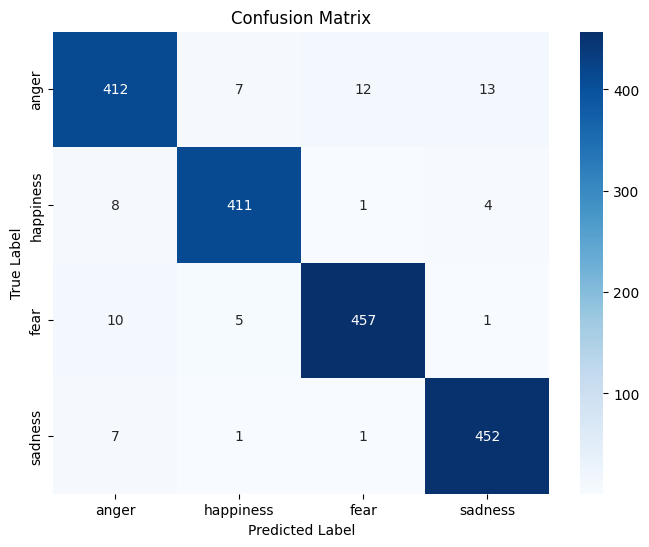

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Label kelas (urutan harus sesuai dengan label yang kamu pakai)
labels = ['anger', 'happiness', 'fear', 'sadness']  # Ganti sesuai label kamu ya

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
